<a href="https://colab.research.google.com/github/eleshuk/machine_learning/blob/main/eleshuk_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
from google.colab import drive
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [44]:
def load_and_preprocess(filepath, n_lags=12):
    # Load data
    # TODO
    drive.mount('/content/drive')
    df = pd.read_csv(filepath)

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['year_month'] = df['date'].dt.to_period('M')
    monthly_df = df.groupby('year_month').median().reset_index()

    # Create feature columns
    feature_cols = ['rainfall_mm', 'temperature_C', 'drainage_m3', 'river_hydrometry_m']
    for col in feature_cols:
        for lag in range(0, n_lags + 1):
            monthly_df[f'{col}_lag{lag}'] = monthly_df[col].shift(lag)

    lagged_feature_cols = [col for col in monthly_df.columns if 'lag' in col]  # <-- save these

    X = monthly_df[lagged_feature_cols]
    y = monthly_df['depth_to_groundwater_m']

    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    groups = monthly_df.loc[valid_idx, 'year_month'].astype(str)

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, groups, lagged_feature_cols

In [45]:
# Build, tune, evaluate model
def build_model():
    return RandomForestRegressor(random_state=42)

# Tune hyperparameters
def tune_model(X_scaled, y, groups, n_iter=20, cv_splits=5):
    # Define a range of hyperparameters to search
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    model = RandomForestRegressor(random_state=42)
    gkf = GroupKFold(n_splits=cv_splits)

    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist,
        n_iter=n_iter, cv=gkf, random_state=42,
        scoring='neg_mean_absolute_error', n_jobs=-1
    )
    random_search.fit(X_scaled, y, groups=groups)

    print("Best Hyperparameters:", random_search.best_params_)
    return random_search.best_estimator_

# Evaluate model
def evaluate_model(model, X_scaled, y, groups, n_splits=5):
    gkf = GroupKFold(n_splits=n_splits)
    scores = cross_val_score(
        model, X_scaled, y, groups=groups, cv=gkf, scoring='neg_mean_absolute_error'
    )
    print(f"Mean MAE: {-scores.mean():.4f} ± {scores.std():.4f}")

In [46]:
# Plot feature importance
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    n_features = len(feature_names)

    # Fix: make sure top_n doesn't exceed available features
    top_n = min(top_n, n_features)

    indices = np.argsort(importances)[::-1][:top_n]

    # Now use feature_names directly (no fancy DataFrame)
    top_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importances[indices], align="center")
    plt.yticks(range(top_n), top_features)
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Important Features")
    plt.tight_layout()
    plt.show()

In [48]:
# Plot model performance
# Actual vs. predicted for one fold
def plot_actual_vs_predicted(model, X_scaled, y, groups):
    gkf = GroupKFold(n_splits=5)
    for train_idx, test_idx in gkf.split(X_scaled, y, groups):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        # Use .iloc to split data - when X is not scaled
        # X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)  # Now X_train is defined
        y_pred = model.predict(X_test)

        plt.figure(figsize=(8, 5))
        plt.plot(y_test.values, label="Actual", marker='o')
        plt.plot(y_pred, label="Predicted", marker='x')
        plt.title("Actual vs Predicted Groundwater Depth")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Depth to Groundwater (m)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Just one fold for visualization
        break

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Mean MAE: 1.4327 ± 0.0755


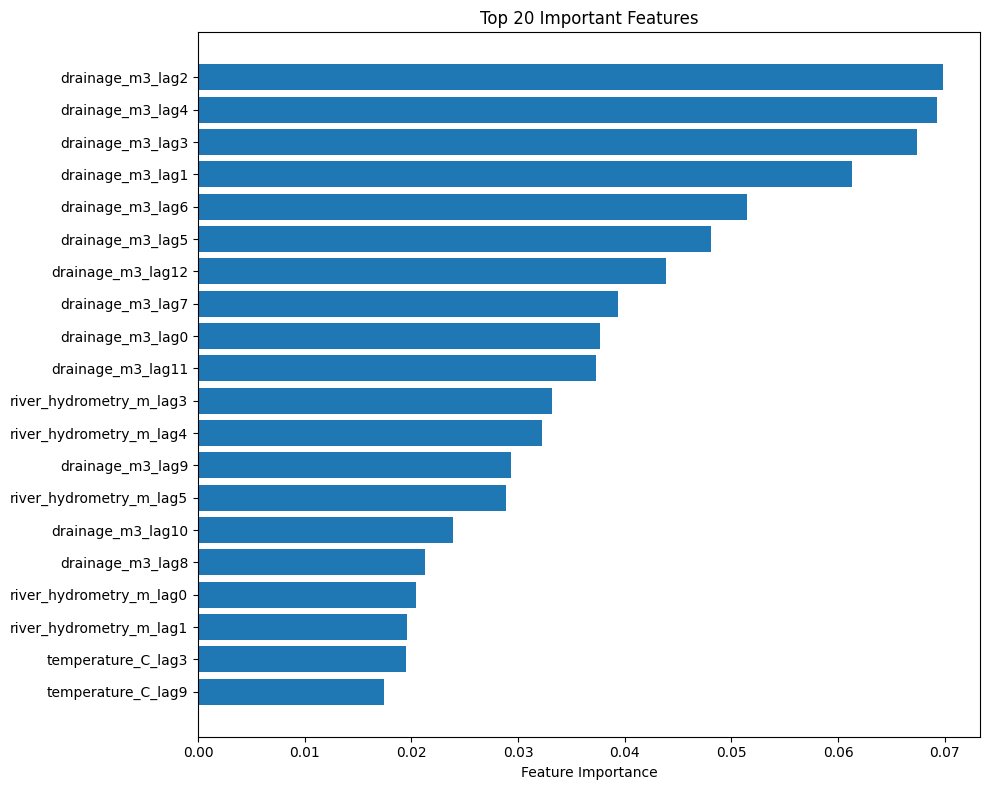

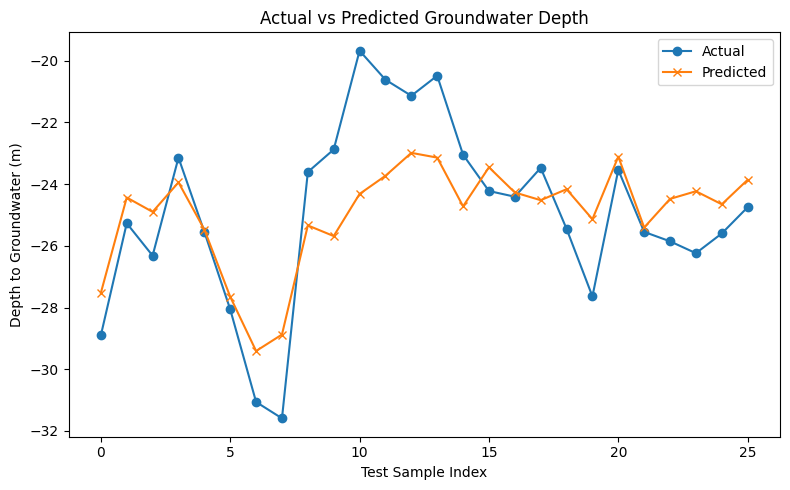

In [49]:
# Main function
def main():
    filepath = '/content/drive/My Drive/aquifer_time_series (2).csv'
    X_scaled, y, groups, feature_names = load_and_preprocess(filepath)

    # Hyperparameter tuning
    best_model = tune_model(X_scaled, y, groups)

    # Evaluate best model
    evaluate_model(best_model, X_scaled, y, groups)

    # Plot Feature Importance
    plot_feature_importance(best_model, feature_names)

    # Plot Actual vs Predicted
    plot_actual_vs_predicted(best_model, X_scaled, y, groups)

if __name__ == "__main__":
    main()